### 1. Load & Prepare Data

In [41]:
# import libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from statsmodels.tsa.statespace.sarimax import SARIMAX, SARIMAXResults   # SARIMA Model
import statsmodels.api as sm  # Required for ADF test

# load data
df_DA = pd.read_excel('./Data/data_all.xlsx')

df_DA.head()

,time,DA_price,grid load [MWh],Residual load [MWh],Total [MWh],Photovoltaics and wind [MWh],Wind offshore [MWh],Wind onshore [MWh],Photovoltaics [MWh]
0,2019-01-01 00:00:00,28.32,43213.25,19264.50,51011.0,23948.75,5069.00,18879.75,0.0
1,2019-01-01 01:00:00,10.07,41275.75,15607.00,51017.0,25668.75,5042.25,20626.50,0.0
2,2019-01-01 02:00:00,-4.08,40187.50,12803.50,51438.0,27384.00,5028.50,22355.50,0.0
3,2019-01-01 03:00:00,-9.91,39909.00,10898.75,52608.0,29010.25,4977.75,24032.50,0.0
4,2019-01-01 04:00:00,-7.41,40258.00,9898.75,53566.0,30359.25,4907.25,25452.00,0.0


In [42]:
# Set time column as Index column
df_DA.set_index('time', inplace=True)
df_DA.head()

,DA_price,grid load [MWh],Residual load [MWh],Total [MWh],Photovoltaics and wind [MWh],Wind offshore [MWh],Wind onshore [MWh],Photovoltaics [MWh]
time,,,,,,,,
2019-01-01 00:00:00,28.32,43213.25,19264.50,51011.0,23948.75,5069.00,18879.75,0.0
2019-01-01 01:00:00,10.07,41275.75,15607.00,51017.0,25668.75,5042.25,20626.50,0.0
2019-01-01 02:00:00,-4.08,40187.50,12803.50,51438.0,27384.00,5028.50,22355.50,0.0
2019-01-01 03:00:00,-9.91,39909.00,10898.75,52608.0,29010.25,4977.75,24032.50,0.0
2019-01-01 04:00:00,-7.41,40258.00,9898.75,53566.0,30359.25,4907.25,25452.00,0.0


In [43]:
df_DA.describe().T

,count,mean,std,min,25%,50%,75%,max
DA_price,52644.0,95.609836,99.003760,-500.00,36.4675,66.160,115.0925,936.28
grid load [MWh],52620.0,54234.948655,9238.656476,30544.75,46682.1875,54118.125,61919.5625,77585.75
Residual load [MWh],52620.0,33728.515541,13014.164822,-14040.25,25286.9375,34619.625,42863.5625,70214.25
Total [MWh],52596.0,53236.719903,11742.658122,20000.00,44621.0000,53260.000,61605.2500,87389.00
Photovoltaics and wind [MWh],52644.0,20514.833457,12487.166134,320.50,10073.9375,18688.375,29322.1250,69742.75
Wind offshore [MWh],52644.0,2850.267196,1854.587775,15.50,1122.2500,2699.375,4518.5625,6772.75
Wind onshore [MWh],52644.0,11794.273369,9404.881481,161.25,4475.0000,8943.375,16777.5625,46617.25
Photovoltaics [MWh],52644.0,5870.292892,9069.427458,0.00,0.0000,214.625,9288.5625,48155.50


### 2.Test Stationarity (ADF Test)

In [44]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(df_DA['DA_price'].dropna())  # Ensure you pass the Series
print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")

ADF Statistic: -7.913475419939992
p-value: 3.891753407179796e-12


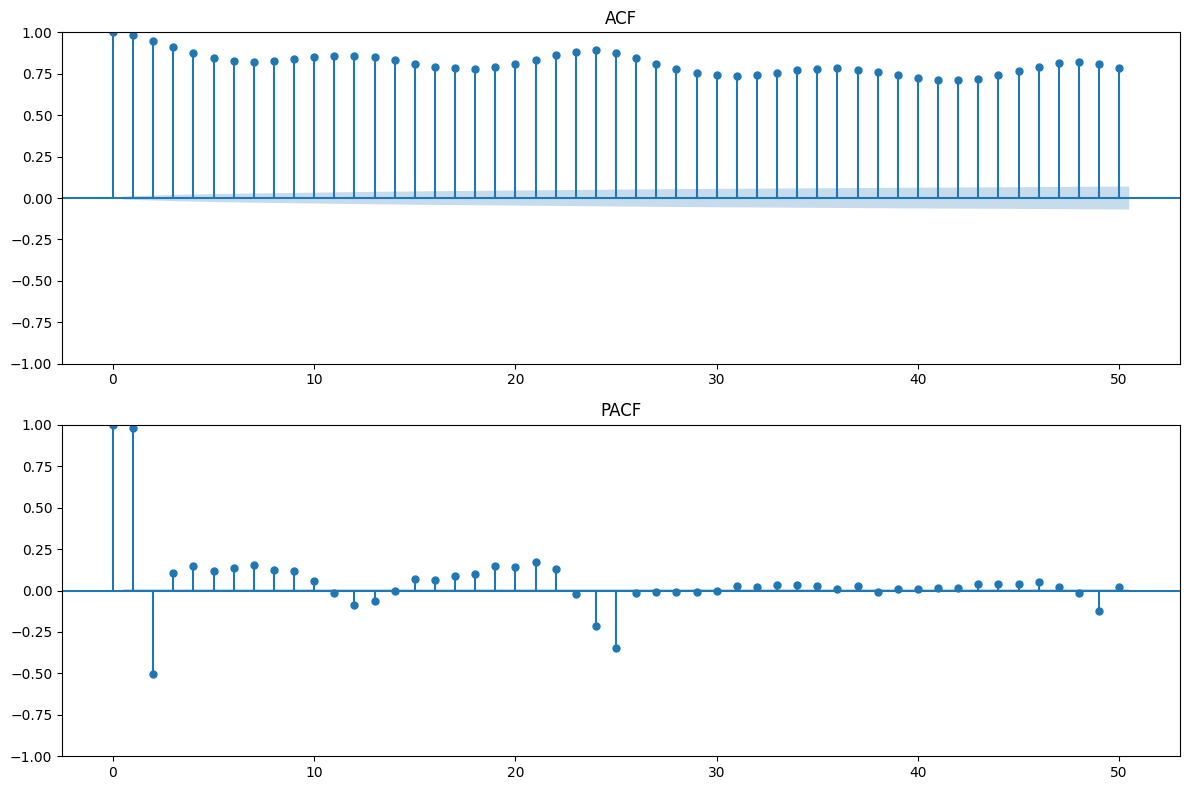

In [45]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

# Use your original (stationary) series
series = df_DA['DA_price'].dropna()

# Plot ACF and PACF
fig, ax = plt.subplots(2, 1, figsize=(12, 8))

plot_acf(series, ax=ax[0], lags=50)
plot_pacf(series, ax=ax[1], lags=50, method='ywm')  # 'ywm' is robust for PACF

ax[0].set_title("ACF")
ax[1].set_title("PACF")

plt.tight_layout()
plt.show()

### Key Observations
ACF shows:

Slow decay (not cutting off sharply) - suggests AR component is needed

Significant spikes at regular intervals (seasonal pattern)

PACF shows:

Sharp cutoff after lag 1 (suggests AR(1) component)

Significant spikes at seasonal lags

Recommended SARIMA Parameters:
For non-seasonal components:

p (AR): 1 (PACF cuts off after lag 1)

d (Differencing): Likely 1 (if your data isn't stationary)

q (MA): 0 or 1 (ACF doesn't show clear MA pattern)

For seasonal components (assuming daily data with 24-hour seasonality):

s (Seasonality): 24 (for hourly prices with daily pattern)

P (Seasonal AR): 1 (seasonal spikes in PACF)

D (Seasonal Differencing): 1 (if seasonal pattern isn't stationary)

Q (Seasonal MA): 1 (seasonal spikes in ACF)
=>(more explanation)

### 3. Train-Test Split

In [46]:
# Resample to ensure regular hourly frequency
df_DA = df_DA.resample('h').mean()

In [47]:
# Split data
train = df_DA[:"2024-11-30 23:00"]
test = df_DA["2024-12-01 00:00":]  # 1-Month test set

### 4. Fit SARIMA Model

In [48]:
# Fit SARIMA model with daily seasonality
model = SARIMAX(train['DA_price'],
                order=(1,0,1),               # (p,d,q)
                seasonal_order=(1,1,1,24),  # (P,D,Q,s)
                enforce_stationarity=False,
                enforce_invertibility=False)

results = model.fit()

### 5. Forecast 

In [49]:
# Forecast same length as test set
forecast = results.get_forecast(steps=len(test))
forecast_mean = forecast.predicted_mean

### 6. Plot Results (Forecast vs Actual)

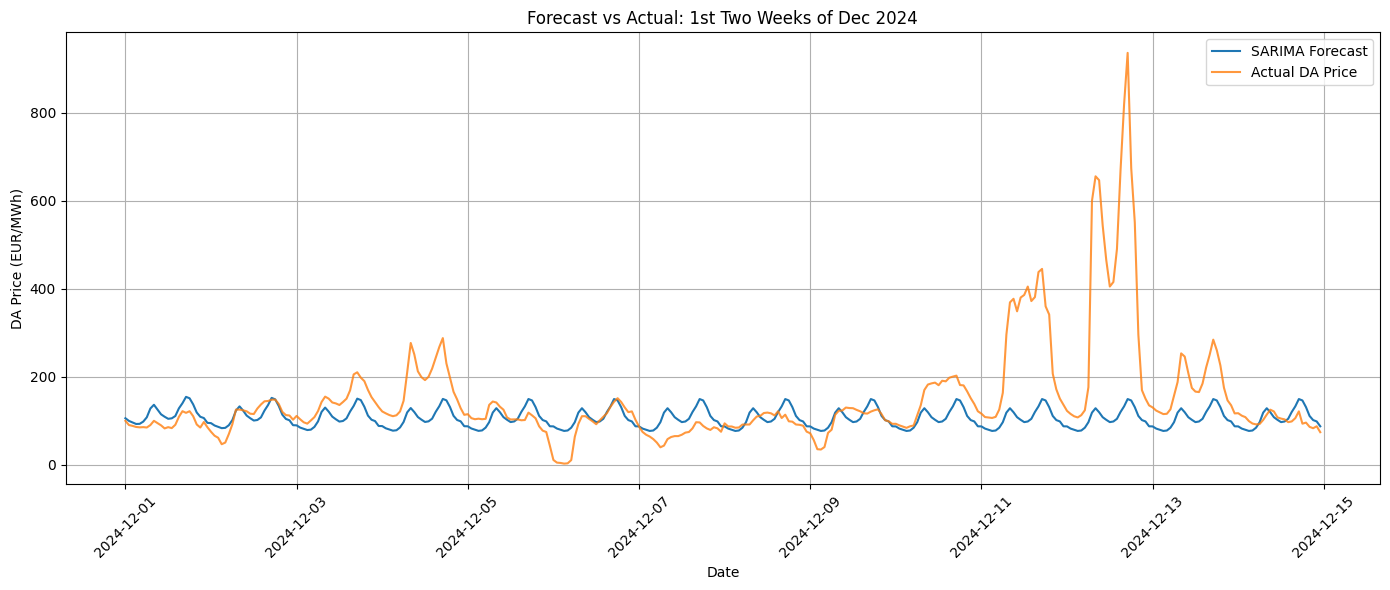

In [50]:
import matplotlib.pyplot as plt

# Select 2-week range
start = '2024-12-01'
end = '2024-12-14'

# Plot SARIMA forecast vs actual
plt.figure(figsize=(14,6))

# Ensure both are pandas Series/DataFrames with datetime index
plt.plot(forecast_mean[start:end], label='SARIMA Forecast')
plt.plot(test['DA_price'][start:end], label='Actual DA Price', alpha=0.8)

plt.title('Forecast vs Actual: 1st Two Weeks of Dec 2024')
plt.xlabel('Date')
plt.ylabel('DA Price (EUR/MWh)')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### 7. Evaluate Forecast

In [51]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Calculate standard metrics
mae = mean_absolute_error(test['DA_price'], forecast_mean)
mse = mean_squared_error(test['DA_price'], forecast_mean)
rmse = np.sqrt(mse)

# Calculate Maximum Prediction Error (MPE)
absolute_errors = np.abs(test['DA_price'] - forecast_mean)
mpe = np.max(absolute_errors)
mpe_index = absolute_errors.idxmax()  # Timestamp of worst prediction

print(f"MAE: {mae:.2f} €/MWh")
print(f"RMSE: {rmse:.2f} €/MWh")
print(f"MPE: {mpe:.2f} €/MWh at {mpe_index}")

# Optional: Show the worst prediction details
print("\nWorst prediction details:")
print(f"Actual: {test.loc[mpe_index, 'DA_price']:.2f} €/MWh")
print(f"Forecast: {forecast_mean.loc[mpe_index]:.2f} €/MWh")
print(f"Error: {mpe:.2f} €/MWh ({mpe/test.loc[mpe_index, 'DA_price']*100:.1f}%)")

MAE: 48.02 €/MWh
RMSE: 88.09 €/MWh
MPE: 787.13 €/MWh at 2024-12-12 17:00:00

Worst prediction details:
Actual: 936.28 €/MWh
Forecast: 149.15 €/MWh
Error: 787.13 €/MWh (84.1%)


In [53]:
# Select features
exog_vars = ['Residual load [MWh]', 'Photovoltaics and wind [MWh]']

# Create train and test sets (same split as before)
train = df_DA['2024-09-01':'2024-11-30']
test = df_DA['2024-12-01':]

# Prepare exogenous features
train_exog = train[exog_vars]
test_exog = test[exog_vars]

In [54]:
# Fit SARIMA model with daily seasonality

from statsmodels.tsa.statespace.sarimax import SARIMAX

model = SARIMAX(train['DA_price'],
                exog=train_exog,
                order=(1,0,1),               # (p,d,q)
                seasonal_order=(1,1,1,24),  # (P,D,Q,s)
                enforce_stationarity=False,
                enforce_invertibility=False)

results = model.fit()

In [55]:
# Forecast same length as test set
forecast_mean = results.predict(start=test.index[0], end=test.index[-1], exog=test_exog)

In [56]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Calculate standard metrics
mae = mean_absolute_error(test['DA_price'], forecast_mean)
mse = mean_squared_error(test['DA_price'], forecast_mean)
rmse = np.sqrt(mse)

# Calculate Maximum Prediction Error (MPE)
absolute_errors = np.abs(test['DA_price'] - forecast_mean)
mpe = np.max(absolute_errors)
mpe_index = absolute_errors.idxmax()  # Timestamp of worst prediction

print(f"MAE: {mae:.2f} €/MWh")
print(f"RMSE: {rmse:.2f} €/MWh")
print(f"MPE: {mpe:.2f} €/MWh at {mpe_index}")

# Optional: Show the worst prediction details
print("\nWorst prediction details:")
print(f"Actual: {test.loc[mpe_index, 'DA_price']:.2f} €/MWh")
print(f"Forecast: {forecast_mean.loc[mpe_index]:.2f} €/MWh")
print(f"Error: {mpe:.2f} €/MWh ({mpe/test.loc[mpe_index, 'DA_price']*100:.1f}%)")

MAE: 24.39 €/MWh
RMSE: 65.35 €/MWh
MPE: 719.53 €/MWh at 2024-12-12 17:00:00

Worst prediction details:
Actual: 936.28 €/MWh
Forecast: 216.75 €/MWh
Error: 719.53 €/MWh (76.8%)


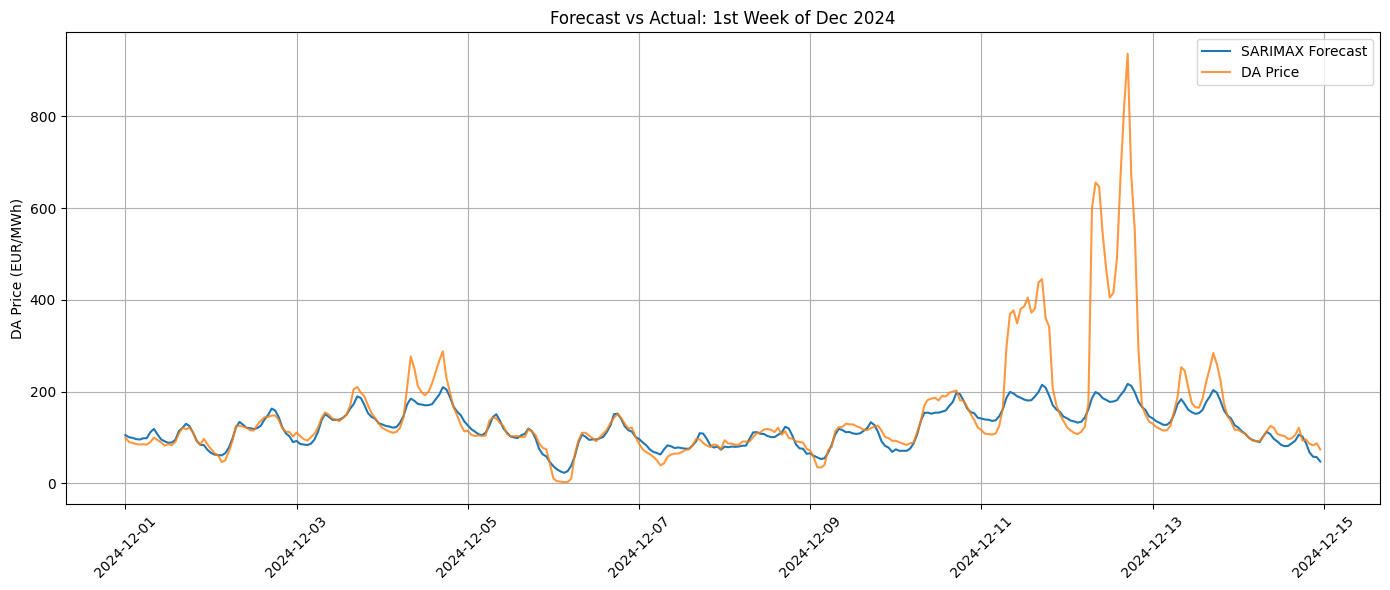

In [57]:
import matplotlib.pyplot as plt

# Select 2-week range
start = '2024-12-01'
end = '2024-12-14'

# Plot SARIMA forecast vs actual
plt.figure(figsize=(14,6))

# Ensure both are pandas Series/DataFrames with datetime index
plt.plot(forecast_mean[start:end], label='SARIMAX Forecast')
plt.plot(test['DA_price'][start:end], label='DA Price', alpha=0.8)

plt.title('Forecast vs Actual: 1st Week of Dec 2024')
plt.xlabel('')
plt.ylabel('DA Price (EUR/MWh)')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### 10. Naive Benchmark

Naive Forecast — MAE: 45.21 €/MWh, RMSE: 80.76 €/MWh


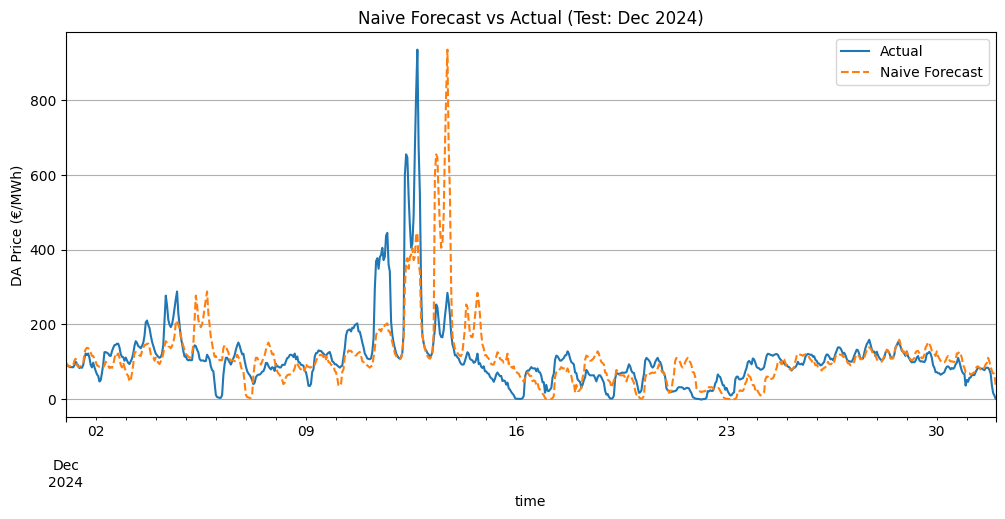

In [58]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

# Ensure datetime index
df_DA.index = pd.to_datetime(df_DA.index)

# Define train and test sets
train = df_DA[:'2024-11-30']
test = df_DA['2024-12-01':]

# Combine for lagging
full_data = pd.concat([train, test])

# Naive forecast: use yesterday’s price at same hour (lag 24)
naive_forecast = full_data['DA_price'].shift(24).loc[test.index]

# Evaluation
mae_naive = mean_absolute_error(test['DA_price'], naive_forecast)
mse_naive = mean_squared_error(test['DA_price'], naive_forecast)
rmse_naive = np.sqrt(mse_naive)

print(f"Naive Forecast — MAE: {mae_naive:.2f} €/MWh, RMSE: {rmse_naive:.2f} €/MWh")

# Optional: Plot actual vs naive
plt.figure(figsize=(12, 5))
test['DA_price'].plot(label='Actual')
naive_forecast.plot(label='Naive Forecast', linestyle='--')
plt.title("Naive Forecast vs Actual (Test: Dec 2024)")
plt.ylabel("DA Price (€/MWh)")
plt.legend()
plt.grid(True)
plt.show()
